<a href="https://colab.research.google.com/github/ontenkutsenko/NLP_Airbnb_Delisting_Prediction/blob/main/Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
!pip install langdetect

In [48]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from langdetect import detect, DetectorFactory

In [49]:
!gdown 1Y63uPJCSWvlefU-HYpuVumaiqgjHjpb8

Downloading...
From (original): https://drive.google.com/uc?id=1Y63uPJCSWvlefU-HYpuVumaiqgjHjpb8
From (redirected): https://drive.google.com/uc?id=1Y63uPJCSWvlefU-HYpuVumaiqgjHjpb8&confirm=t&uuid=c28d7044-1c56-4d7f-aa7c-ceaaec2840c7
To: /content/Project Corpora.zip
100% 55.4M/55.4M [00:00<00:00, 143MB/s]


In [50]:
!unzip '/content/Project Corpora.zip'

Archive:  /content/Project Corpora.zip
replace Project Corpora/test.xlsx? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: Project Corpora/test.xlsx  
  inflating: Project Corpora/test_reviews.xlsx  
  inflating: Project Corpora/train.xlsx  
  inflating: Project Corpora/train_reviews.xlsx  


In [51]:
!rm '/content/Project Corpora.zip'

In [52]:
df_train = pd.read_excel('/content/Project Corpora/train.xlsx')
df_train_reviews = pd.read_excel('/content/Project Corpora/train_reviews.xlsx')
df_test = pd.read_excel('/content/Project Corpora/test.xlsx')
df_test_reviews = pd.read_excel('/content/Project Corpora/test_reviews.xlsx')

In [53]:
df_train

,index,description,host_about,unlisted
0,1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0
1,2,"O meu espaço fica perto de Parque Eduardo VII,...","I am friendly host, and I will try to always b...",1
2,3,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re...",1
3,4,"Apartamento Charmoso no Chiado, Entre o Largo ...",Hello!_x000D_\nI m Portuguese and i love to me...,0
4,5,Joli appartement en bordure de mer.<br /> 2 m...,Nous sommes une famille avec deux enfants de 1...,0
...,...,...,...,...
6243,6244,"Studio 15 is a new, very well decorated and co...",I'm a Brand Manager from Lisbon in Portugal bu...,0
6244,6245,Lisbon meets a cosmopolitan industrial one-bed...,Home is where feelings are visitors. How do we...,0
6245,6246,<b>License number</b><br />Exempt,I am a travel agent passionate by cultures. \n...,1
6246,6247,Campo Pequeno Prestige is a classy and top qua...,Família_x000D_\nPortugal_x000D_\nGavião_x000D_...,0


In [54]:
df_train_reviews.head(30)

,index,comments
0,1,this is a very cozy and comfortable house to s...
1,1,good<br/>
2,1,"My first hostel experience, and all I have to ..."
3,1,Das Hostel war neu und deshalb funktionierte a...
4,1,"It was fine for a dorm, but I think for the pe..."
5,1,Our stay in Lisbon Tip Hostel was very good. T...
6,1,Close to shops in town and a comfortable place...
7,1,Young and friendly staff. Great location along...
8,1,The place is just off the Parque metro stop wh...
9,1,Had a nice stay at this hostel. The beds were ...


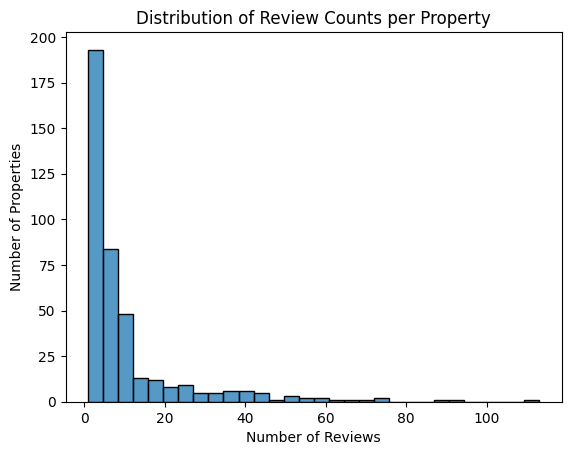

In [55]:
sns.histplot(df_train_reviews['index'].value_counts().value_counts(), bins=30)
plt.title('Distribution of Review Counts per Property')
plt.xlabel('Number of Reviews')
plt.ylabel('Number of Properties')
plt.show()

In [56]:
df_train_reviews['index'].value_counts().value_counts()

count
1      113
2       92
3       89
4       75
7       73
      ... 
328      1
325      1
324      1
322      1
891      1
Name: count, Length: 410, dtype: int64

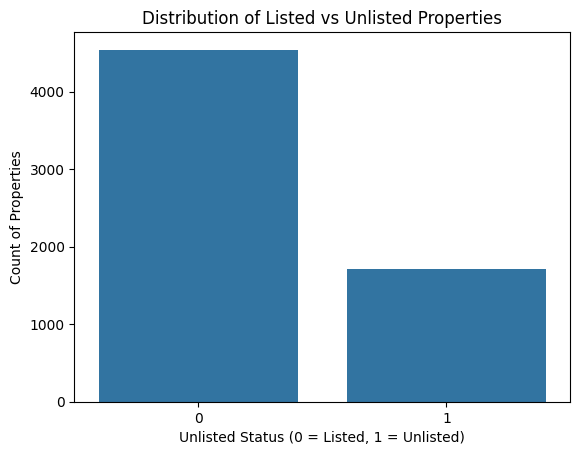

In [57]:
sns.countplot(x='unlisted', data=df_train)
plt.title('Distribution of Listed vs Unlisted Properties')
plt.xlabel('Unlisted Status (0 = Listed, 1 = Unlisted)')
plt.ylabel('Count of Properties')
plt.show()

# Let's merge the dataframes (Not sure if that's best but if we use it for predictions let's try) and check for languages

In [58]:
df_train_reviews['comments'] = df_train_reviews['comments'].fillna('').astype(str)

In [59]:
# check for languages

DetectorFactory.seed = 0

def detect_language(text):
    try:
        return detect(text)
    except:
        return 'error'

In [60]:
aggregated_reviews = df_train_reviews.groupby('index')['comments'].agg(
    all_comments=' '.join,  # Concatenates all comments into a single string
).reset_index()

aggregated_reviews['language_in_comments'] = aggregated_reviews['all_comments'].apply(detect_language)

In [61]:
df_train = pd.merge(df_train, aggregated_reviews, on='index', how='left')

df_train['all_comments'].fillna('', inplace=True)
df_train['language_in_comments'].fillna('No Reviews', inplace=True)


df_train.head(30)

,index,description,host_about,unlisted,all_comments,language_in_comments
0,1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0,this is a very cozy and comfortable house to s...,en
1,2,"O meu espaço fica perto de Parque Eduardo VII,...","I am friendly host, and I will try to always b...",1,,NaN
2,3,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re...",1,,NaN
3,4,"Apartamento Charmoso no Chiado, Entre o Largo ...",Hello!_x000D_\nI m Portuguese and i love to me...,0,,NaN
4,5,Joli appartement en bordure de mer.<br /> 2 m...,Nous sommes une famille avec deux enfants de 1...,0,Un très bel appartement avec une magnifique vu...,en
5,6,"IMPORTANT: In response to COVID-19, this prope...","Hi, we are Homing - a company that develops it...",0,,NaN
6,7,This is my home that I rent out when I'm trave...,Globe trotter. I'm of Portuguese nationality w...,1,,NaN
7,8,Find tranquility in this meticulously curated ...,I travel a lot and I love it. _x000D_\nOrigina...,0,Shani was very helpful throughout our process!...,en
8,9,Charming apartment with one bedroom with doubl...,"Isabel & Helder, portugueses, parents of three...",0,Nous avons passé un très bon séjour chez Isabe...,en
9,10,Walk up original wooden stairs to the entrance...,Serviced holiday apartments casa in Azenhas do...,0,"WOW, what a great stay! The spacious apartment...",en


# Some preprocessing and maybe some statistics

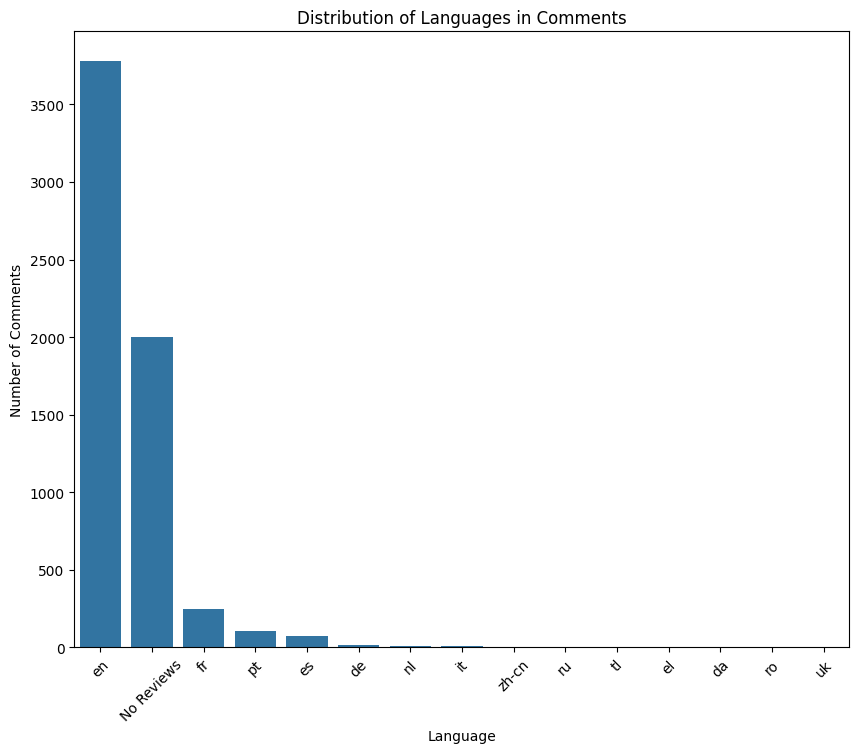

In [63]:
language_counts = df_train['language_in_comments'].value_counts()
plt.figure(figsize=(10, 8))
sns.barplot(x=language_counts.index, y=language_counts.values)
plt.title('Distribution of Languages in Comments')
plt.xlabel('Language')
plt.ylabel('Number of Comments')
plt.xticks(rotation=45)
plt.show()

In [66]:
df_train['language_in_comments'].value_counts(normalize=True)

language_in_comments
en            0.605314
No Reviews    0.320583
fr            0.039213
pt            0.016805
es            0.011204
de            0.002561
nl            0.001761
it            0.001280
zh-cn         0.000320
ru            0.000160
tl            0.000160
el            0.000160
da            0.000160
ro            0.000160
uk            0.000160
Name: proportion, dtype: float64

In [69]:
pd.set_option('display.max_colwidth', None)
df_train[df_train['language_in_comments']=='fr']['all_comments'].head(5)

19                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [70]:
# actually comments a re several languages so what can we do ????